In [97]:
import scipy.io
import scipy.spatial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from pydmd import MrDMD
from pydmd import DMD
import seaborn as sns

In [55]:
ecog_data_1 = scipy.io.loadmat('ECoG_Handpose.mat')
#ecog_data_2 = scipy.io.loadmat('011-2015-2.mat')

In [56]:
# Matlab files are dictionaries, let's see the keys
for key, value in ecog_data_1.items() :
    print (key)

__header__
__version__
__globals__
y


In [57]:
data = ecog_data_1["y"].T
data.shape

(507025, 67)

In [58]:
#data_2 = ecog_data_2["datainmicrovolts"]
#data_2.shape

### Building DMD

In [59]:
first_dmd = DMD(svd_rank= -1 , opt = True,)
first_dmd.fit(X=data)

/home/bci/.local/lib/python3.8/site-packages/pydmd/dmdbase.py:213: UserWarning: Input data matrix X has condition number 18815863.915751666. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  warnings.warn("Input data matrix X has condition number {}. "


In [60]:
#second_dmd = DMD(svd_rank= -1 , opt = True)
#second_dmd.fit(X=data_2)

In [101]:
mm = (abs(first_dmd.modes.T) - abs(first_dmd.modes.T).mean())/abs(first_dmd.modes.T).std()

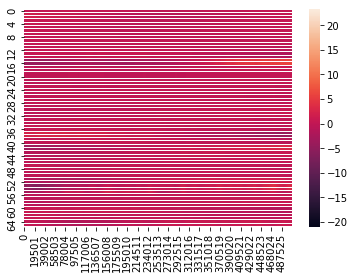

In [102]:
sns.heatmap(mm)

In [62]:
f_dmd_ampl = abs(first_dmd.amplitudes)
#s_dmd_ampl = abs(second_dmd.amplitudes)

In [63]:
f_dmd_data = first_dmd.reconstructed_data

In [64]:
#s_dmd_data = second_dmd.reconstructed_data

In [65]:
f_dmd_data.shape

(507025, 67)

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


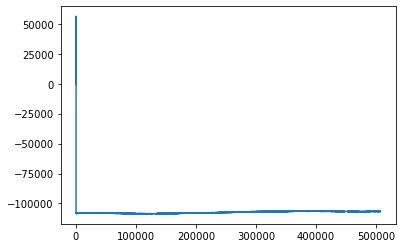

In [66]:
plt.plot(f_dmd_data[:,1])

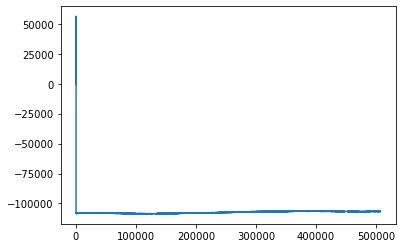

In [67]:
plt.plot(data[:,1])

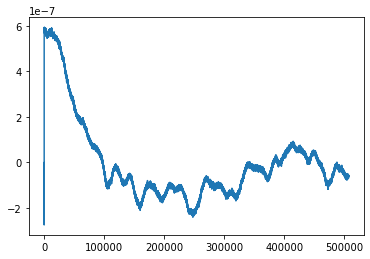

In [68]:
plt.plot(f_dmd_data[:,1] - data[:,1])

The number of eigenvalues is 66


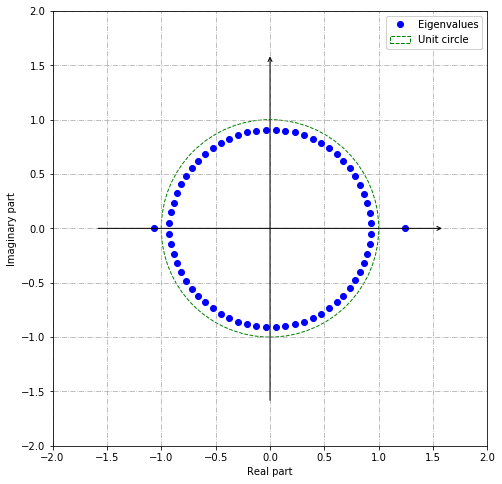

In [69]:
print('The number of eigenvalues is {}'.format(first_dmd.eigs.shape[0]))
first_dmd.plot_eigs(show_axes=True, show_unit_circle=True, figsize=(8, 8))

In [70]:
#plt.plot(s_dmd_data[:,1])

In [71]:
#plt.plot(data_2[:,1])

In [72]:
#plt.plot(s_dmd_data[:,1] - data_2[:,1])

In [73]:
#print('The number of eigenvalues is {}'.format(second_dmd.eigs.shape[0]))
#second_dmd.plot_eigs(show_axes=True, show_unit_circle=True, figsize=(8, 8))

## Cosine Similarity 

In [74]:
#scipy.spatial.distance.cosine(f_dmd_ampl, s_dmd_ampl)

## Augmenting X matrix
ref: B.W.Brunton et al (2016)

In [75]:
data.shape

(507025, 67)

In [76]:
X_raw = data[24000:26400,:].T
X_raw.shape

(67, 2400)

In [77]:
h_star = 5 #rule of thumb n*h > 2*m
size_1_X_aug = X_raw.shape[1] - h_star
if h_star > 1:
    X_aug = np.zeros((X_raw.shape[0],size_1_X_aug))
    for st in range(1,h_star):
        X_aug = np.concatenate((X_aug, X_raw[:,st:-h_star +st]))
    
    X_aug = X_aug[X_raw.shape[0]:,:]
    
    X = X_aug[:,:-1]
    Y = X_aug[:,1:]
else:
    X = X_aug[:,:-1]
    Y = X_aug[:,1:]

In [78]:
X_aug.T.shape

(2395, 268)

In [79]:
def aug_dmd_features(X_raw, h_star = 5):
    #rule of thumb n*h > 2*m
    
    ### Augmentation as in Brunton (2016)
    size_1_X_aug = X_raw.shape[1] - h_star
    if h_star > 1:
        X_aug = np.zeros((X_raw.shape[0],size_1_X_aug))
        for st in range(1,h_star):
            X_aug = np.concatenate((X_aug, X_raw[:,st:-h_star +st]))

        X_aug = X_aug[X_raw.shape[0]:,:]

        X = X_aug[:,:-1]
        Y = X_aug[:,1:]
    else:
        X = X_aug[:,:-1]
        Y = X_aug[:,1:]
    
    #### DMD features extraction
    neuro_dmd = DMD(svd_rank= h_star*X_raw.shape[0], opt = True)
    neuro_dmd.fit(X_aug.T)
    #### DMD eigenvalues
    real_dmd = neuro_dmd.amplitudes.real
    imag_dmd = neuro_dmd.amplitudes.imag
    
    #### DMD matrix 
    matrix_dmd = neuro_dmd.atilde
    
    return matrix_dmd

In [80]:
prova = aug_dmd_features(X_raw = data[24000:26400,:].T)

/home/bci/.local/lib/python3.8/site-packages/pydmd/dmdbase.py:213: UserWarning: Input data matrix X has condition number 1.0902937476756939e+20. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  warnings.warn("Input data matrix X has condition number {}. "


In [81]:
prova.shape

(267, 267)

In [82]:
prova

array([[ 5.09401014e-01, -4.67271297e+01, -3.42761841e+02, ...,
        -3.92220791e+04,  1.31143562e+07, -1.88568431e+07],
       [-9.97443957e-05,  2.72290408e-01,  9.83662451e-01, ...,
         4.77649012e+06, -7.78869367e+07,  1.25159897e+08],
       [-1.10079646e-04,  7.67192783e-02,  6.85802028e-01, ...,
         3.32538452e+07, -4.24816321e+08,  6.20216389e+08],
       ...,
       [-4.74770252e-18,  3.69884219e-15,  1.52564932e-15, ...,
        -2.02836842e-04,  7.41152080e-03, -4.29668537e-02],
       [-7.88540960e-17,  4.70124410e-15,  3.48143533e-14, ...,
         7.00986715e-04,  7.88159570e-02,  3.19516226e-01],
       [-6.20499971e-17, -6.20535396e-15,  5.38328346e-14, ...,
         1.46522620e-03,  2.22094763e-02,  5.56978178e-03]])

In [23]:
neuro_dmd = DMD(svd_rank= h_star*X_raw.shape[0], opt = True)
neuro_dmd.fit(X_aug.T)
real_dmd = neuro_dmd.amplitudes.real
imag_dmd = neuro_dmd.amplitudes.imag
matrix_dmd = np.vstack((real_dmd,imag_dmd))

/home/bci/.local/lib/python3.8/site-packages/pydmd/dmdbase.py:213: UserWarning: Input data matrix X has condition number 1.0902937476756939e+20. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  warnings.warn("Input data matrix X has condition number {}. "


The number of eigenvalues is 267


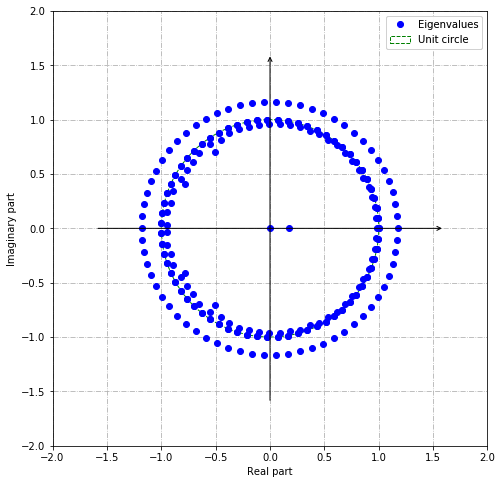

In [131]:
print('The number of eigenvalues is {}'.format(neuro_dmd.eigs.shape[0]))
neuro_dmd.plot_eigs(show_axes=True, show_unit_circle=True, figsize=(8, 8))

In [132]:
neuro_data = neuro_dmd.reconstructed_data

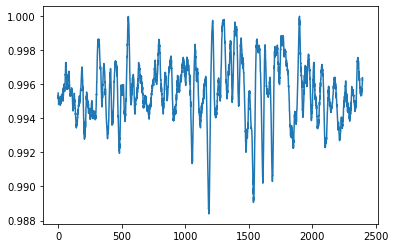

In [133]:
plt.plot(neuro_data[:,100]/neuro_data[:,100].max())

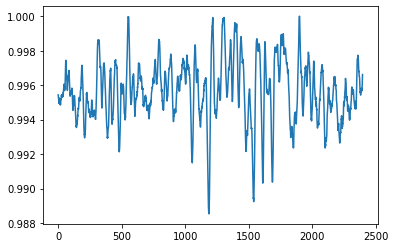

In [134]:
plt.plot(X_aug.T[:,100]/X_aug.T[:,100].max())

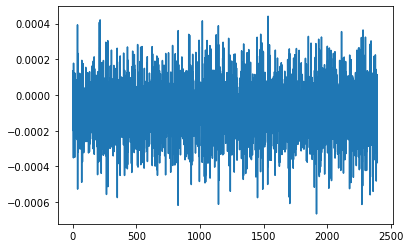

In [135]:
plt.plot(neuro_data[:,100]/neuro_data[:,100].max() - X_aug.T[:,100]/X_aug.T[:,100].max())